In [1]:
%matplotlib inline
# misc. libraries
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# ml libraries
from sklearn import cluster, metrics
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

In [2]:
# local dependencies
from helpers import *

+ **DHT:** Dihydrotestosterone is an endogenous androgen sex steroid and hormone
+ **E2:** Estradiol (E2), also spelled oestradiol, is an estrogen steroid hormone and the major female sex hormone
+ **P4:**  Progesterone (P4) is an endogenous steroid and progestogen sex hormone involved in the menstrual cycle, pregnancy, and embryogenesis of humans and other species

***
**Data loading**
***

In [4]:
# Raw information about genes
genes = load_genes()
genes

dht                 e2                      p4          
          up      down       up        down          up      down
0       KLK3      CPB1      NTS        CPB1        KLK3     RAB31
1       GPC3    CITED1      DCX  AC062028.2      CXCL13       PGR
2      GPR88     GRIK3  COL22A1      SPINK4        DIO2  FLNB-AS1
3    UGT2B11      LYG1    IGSF1       POTEJ         TAT     ZNF71
4       KLK2     DCDC2   NECAB1         ALB     ADAMTS8    ZNF282
5    UGT2B28   ZNRF2P1   PIEZO2       MS4A7      MYBPC1    QRICH1
6    SLC26A3      CISH     TP63      PLA2G3     UGT2B11       NaN
7   TMEM176A    ZNF107  TMPRSS4     CACNA1H       NTRK3       NaN
8       HPGD       GHR    KLK12    CYP4F30P        DLC1       NaN
9     CYP4F8    NFKBIE     HPGD      MS4A14      ABCA13       NaN
10     DHRS2   FAM217B    KLK14    CYP4F29P      GIMAP6       NaN
11    ATP1A2     GFOD1  SCGB3A1      KLF2P3     SLC26A3       NaN
12    TSPAN8     RIPK2    KCNK3       PEX5L       PDE2A       NaN
13   ALOX15B   TNFAIP3    NTRK3       TPSG1     SPARCL1       NaN
14   HSD17B2  TMEM106B     NEFH       NELL2      SYNPO2       NaN
15    COL3A1    FAM92A    GRIK4      FAR2P3       LAMA1       NaN
16   RANBP3L     BICD1    OLFM4    CYP4F62P      CLEC7A       NaN
17      SOX2      FGD6    RFLNA      CRTAC1  AL591034.3       NaN
18    MYBPC1    FAM83B   RUBCNL      SORCS1      ZBTB16       NaN
19    CXCL13   PLEKHO1    GREB1   SOCS2-AS1     ADAMTS1       NaN
20     FGFR4   MAP3K14  SLC34A2     BPIFA4P      PKD1L1       NaN
21   COL12A1      PER2     SDC2        CSTA       CYYR1       NaN

In [5]:
# Preprocessed list of genes

genes_list = load_genes_list()
genes_list.head(2)

,genes,dht,e2,p4,upregulated
0,ABCA13,False,False,True,True
1,AC062028.2,False,True,False,False


In [6]:
# Genes showing response to two hormones

genes_list[genes_list[["dht", "e2", "p4"]].sum(axis=1) == 2]

,genes,dht,e2,p4,upregulated
17,CPB1,True,True,False,False
20,CXCL13,True,False,True,True
46,HPGD,True,True,False,True
54,KLK3,True,False,True,True
60,MYBPC1,True,False,True,True
65,NTRK3,False,True,True,True
85,SLC26A3,True,False,True,True
101,UGT2B11,True,False,True,True


In [35]:
# Label genes into three categories according to list of genes

genes_labeled = pd.DataFrame(genes_list, columns = ['genes'])
genes_labeled['label'] = genes_list.replace(['dht', 'p4', 'e2'], [0, 1, 2])['label']
genes_labeled.head()

,genes,label
0,ABCA13,1
1,AC062028.2,2
2,ADAMTS1,1
3,ADAMTS8,1
4,AL591034.3,1


In [8]:
# Load PDX tumor data
pdx = load_pdx(genes_list.genes)

# Remove control subjects and subjects exposed to two treatments
pdx = pdx[~pdx.index.str.contains(r"\+|CTRL")]

# Extract the label from the index
labels = pdx.index.str.rsplit("_", 1).map(lambda x: x[1].lower())
pdx.insert(0, "label", labels)

In [42]:
# Label pdx data according to treatment response
pdx_labeled = pd.DataFrame(genes_list, columns = ['label'])
pdx_labeled = pdx.replace(['dht', 'p4', 'e2'], [0, 1, 2])['label']
pdx_labeled

PL015_G3_M25_E2    2
PL015_G3_M26_E2    2
PL015_G3_M28_P4    1
PL015_G3_M29_P4    1
PL015_G3_M33_E2    2
PL015_G3_M35_P4    1
PL015_G3_M38_P4    1
PL015_G3_M39_E2    2
T110_G2_M03_E2     2
T110_G2_M05_P4     1
T110_G2_M07_P4     1
T110_G2_M09_E2     2
T110_G2_M12_P4     1
T110_G2_M13_P4     1
T111_G2_M02_DHT    0
T111_G2_M03_E2     2
T111_G2_M06_DHT    0
T111_G2_M07_P4     1
T111_G2_M09_DHT    0
T111_G2_M10_E2     2
T111_G2_M12_E2     2
T111_G2_M14_P4     1
T111_G2_M15_P4     1
Name: label, dtype: int64

In [ ]:
# Load TCGA patient data (first part)
patients = load_patients(genes_list.genes)
patients.head(2)

In [ ]:
# Load TCGA patient data (second part)
patients2 = load_patients2(genes_list.genes)
patients2.head(2)

***
**Exploratory data analysis**
***

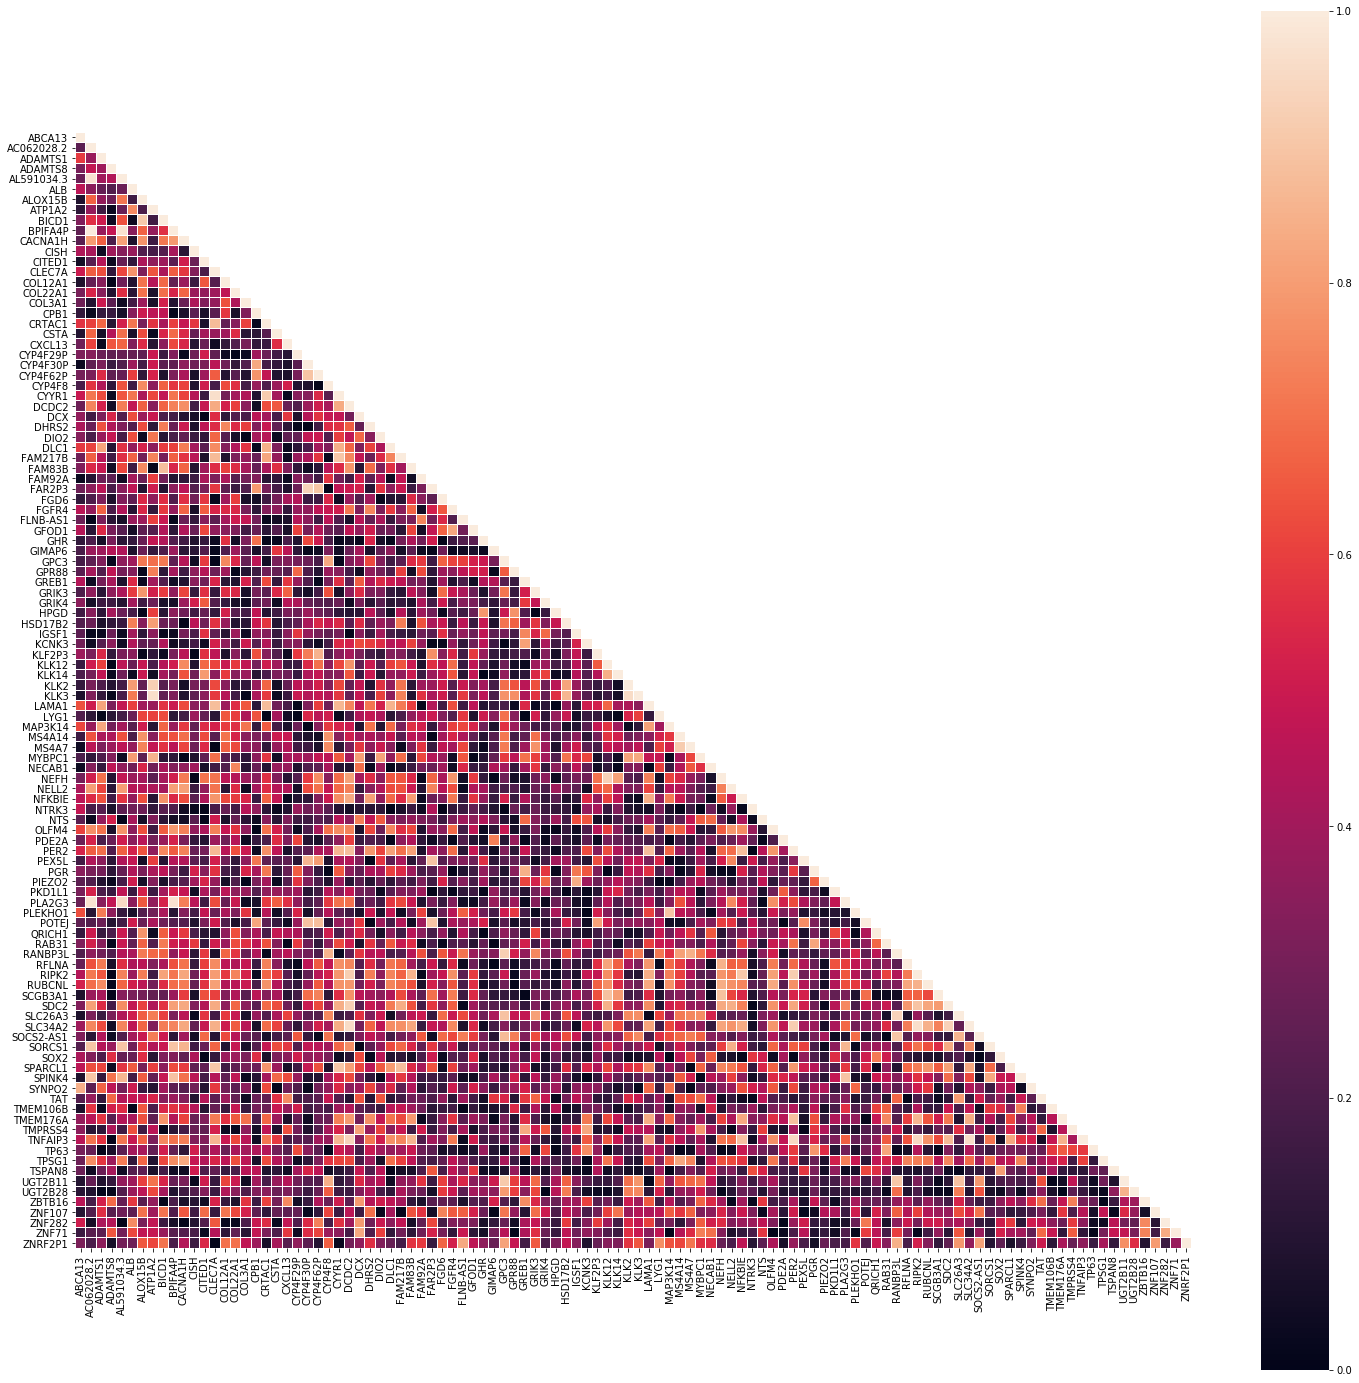

In [9]:
corr = np.abs(np.tril(pdx.corr()))

plt.figure(figsize=(25, 25))
ticklabels = genes_list.genes

heatmap = sns.heatmap(
    corr,
    square=True,
    linewidths=.005,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
    mask=(corr == 0)  # mask cells with missing values
)
fig = heatmap.get_figure()
fig.savefig("corr.png")

***
**Feature processing**
***

In [ ]:
# todo

***
**Clustering**
***

In [60]:
clus = cluster.AgglomerativeClustering(n_clusters=7)#, affinity='manhattan', linkage='average')
predicted = clus.fit_predict(pdx.drop(labels='label', axis=1))
print(pdx_labeled.shape)

# calculate score
score = metrics.adjusted_rand_score(pdx_labeled, predicted)
print(score)
#accuracy, f2 = performance(predicted)

(23,)
0.3477853292711507


In [ ]:
score = metrics.adjusted_rand_score(genes_labeled['label'], predicted)
print(score)

***
**K-Means**
***

In [72]:
kmeans = cluster.KMeans(n_clusters=4, random_state=0).fit(pdx.drop(labels='label', axis=1))
print("predicted labels : " + str(kmeans.labels_))
print("true labels :      " + str(pdx_labeled.values))
print("Score : " + str(metrics.adjusted_rand_score(pdx_labeled, kmeans.labels_)))

predicted labels : [1 1 1 1 1 1 1 1 3 3 3 3 3 0 2 0 2 0 2 0 0 0 0]
true labels :      [2 2 1 1 2 1 1 2 2 1 1 2 1 1 0 2 0 1 0 2 2 1 1]
Score : 0.0903207248669639


In [ ]:
# we should rather evaluate with the metrics.adjusted_rand_score function 

def performance(labels):
    '''Evaluate performance of predicted cluster compared to pre-selected gene list'''
    # get gene list
    geneNP = genes_list.loc[:,'dht':'p4'].astype(int).values  # replace with Boolean values
    
    nb_clusters = len(np.unique(labels))
    accuracy = np.zeros([nb_clusters, 3])
    f2 =  np.zeros([nb_clusters, 3])
    beta = 2
    for i in np.arange(nb_clusters):
        label = np.zeros_like(labels)
        label[labels == i] = 1
        for j in np.arange(geneNP.shape[1]):
            # plot confusion matrices
            
            #cm = metrics.confusion_matrix(geneNP[:,j], label)
            #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            #fig, ax = plt.subplots()
            #im = ax.imshow(cm, interpolation='nearest')
            #ax.figure.colorbar(im, ax=ax)
            accuracy[i,j] = np.mean(geneNP[:,j]==label)
            f2[i,j] = metrics.fbeta_score(geneNP[:,j], label, beta)
    return accuracy, f2
        

***
**Principal Component Analysis**
***

In [ ]:
# PCA decomposition of original gene list
# we want to verify that the pre-selected genes are linearly independent

pca = PCA()
pca.fit(genes_list)
PCA(copy=True, iterated_power='auto', n_components=None,
    random_state=None, svd_solver='auto', tol=0.0, whiten=False)

# Explained variance by PCA
# print(pca.explained_variance_)

# Singular values of PCA
# print(pca.singular_values_)

y_pos = np.arange(len(pca.singular_values_))
plt.bar(y_pos, pca.singular_values_, align='center', alpha=0.5)
plt.ylabel('Values')
plt.xlabel('Principal components')
plt.title('PCA - Singular values')
plt.show()

#
#pca.n_components = 2
#X_reduced = pca.fit_transform(X)
# X_reduced.shape